In [2]:
import os
import math
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

In [3]:
# We import the dataset for the drifting and static data
dataset_drifting = pd.read_parquet('../ourdata/df_drifting_session_798911424.parquet')
# dataset_static = pd.read_parquet('../ourdata/df_static_session_798911424.parquet')

We create the functions that we will use for both the dataset (static and drifting gratings), and then we will start with Unsupervised Clustering, and a Supervised Classification.

In [4]:
def plot_feature_space(dataset, x_col='temporal_frequency', y_col='orientation', figsize=(12, 4), title='Feature Space'):
    """
    Plots a scatterplot of the feature space.

    Parameters:
    - dataset: pandas DataFrame containing the data.
    - x_col: str, name of the feature for the x-axis.
    - y_col: str, name of the feature for the y-axis.
    - figsize: tuple, size of the figure.
    - title: str, title of the plot.

    Returns:
    - None (displays the plot).
    """
    plt.figure(figsize=figsize)
    sns.scatterplot(x=dataset[x_col], y=dataset[y_col])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

In [5]:
def apply_kmeans_clustering(dataset, n_clusters, x_col='temporal_frequency', y_col='orientation', random_state=42):
    """
    Applies K-Means clustering to the dataset and plots the result.

    Parameters:
    - dataset: pandas DataFrame containing the data.
    - n_clusters: int, number of clusters to form.
    - x_col: str, name of the feature to use for the x-axis in the plot.
    - y_col: str, name of the feature to use for the y-axis in the plot.
    - random_state: int, random state for reproducibility.

    Returns:
    - dataset: DataFrame with a new 'KMeans_Cluster' column.
    """
    X = dataset[[x_col, y_col]]
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    dataset['KMeans_Cluster'] = kmeans.fit_predict(X)

    plt.figure(figsize=(12, 4))
    sns.scatterplot(x=dataset[x_col], y=dataset[y_col], hue=dataset['KMeans_Cluster'],
                    palette='viridis', legend=False)
    plt.title('K-Means Clustering')
    plt.show()

    return dataset

In [6]:
def apply_hierarchical_clustering(dataset, n_clusters, x_col='temporal_frequency', y_col='orientation'):
    """
    Applies Agglomerative (Hierarchical) Clustering to the dataset and plots the result.

    Parameters:
    - dataset: pandas DataFrame containing the data.
    - n_clusters: int, number of clusters to form.
    - x_col: str, feature name for x-axis in the plot.
    - y_col: str, feature name for y-axis in the plot.

    Returns:
    - dataset: DataFrame with a new 'Hierarchical_Cluster' column.
    """
    X = dataset[[x_col, y_col]]
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    dataset['Hierarchical_Cluster'] = agglo.fit_predict(X)

    plt.figure(figsize=(12, 4))
    sns.scatterplot(x=dataset[x_col], y=dataset[y_col], hue=dataset['Hierarchical_Cluster'],
                    palette='coolwarm', legend=False)
    plt.title('Hierarchical Clustering')
    plt.show()

    return dataset

In [26]:
def plot_area_cluster_heatmaps(dataset, area_col='area',
                               kmeans_col='KMeans_Cluster',
                               hier_col='Hierarchical_Cluster'):
    """
    Plots heatmaps showing the relationship between brain areas and clustering results.

    Parameters:
    - dataset: pandas DataFrame containing clustering and area columns
    - area_col: name of the column representing brain areas
    - kmeans_col: name of the column with KMeans clustering labels
    - hier_col: name of the column with Hierarchical clustering labels

    Output:
    - Displays two heatmaps: one for KMeans vs Area and one for Hierarchical vs Area
    """
    plt.figure(figsize=(14, 6))

    # KMeans Heatmap
    plt.subplot(1, 2, 1)
    kmeans_ct = pd.crosstab(dataset[area_col], dataset[kmeans_col])
    sns.heatmap(kmeans_ct, annot=True, fmt='d', cmap='Blues')
    plt.title('KMeans Cluster vs Area')
    plt.xlabel('KMeans Cluster')
    plt.ylabel('Brain Area')

    # Hierarchical Heatmap
    plt.subplot(1, 2, 2)
    hier_ct = pd.crosstab(dataset[area_col], dataset[hier_col])
    sns.heatmap(hier_ct, annot=True, fmt='d', cmap='Greens')
    plt.title('Hierarchical Cluster vs Area')
    plt.xlabel('Hierarchical Cluster')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()


In [7]:
def train_area_models(dataset, features, label_col='active', area_col='area', test_size=0.2, random_state=10):
    """
    Trains XGBoost models per area and returns models, results, and a fitted LabelEncoder.

    Returns:
    - models: dict of area -> model
    - results: dict of area -> {'X_test', 'Y_test', 'Y_pred'}
    - label_encoder: fitted LabelEncoder
    """
    models = {}
    results = {}
    label_encoder = LabelEncoder()

    for area, group in dataset.groupby(area_col):
        print(f"Training model for area: {area}")
        
        X = group[features]
        Y = group[label_col]

        if Y.nunique() < 2:
            print(f"Skipping area {area} — only one class present: {Y.unique()}")
            continue

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state
        )
        label_encoder.fit(Y_train)

        model = xgb.XGBClassifier(n_estimators=100, random_state=random_state)
        model.fit(X_train, Y_train)

        Y_pred = model.predict(X_test)

        models[area] = model
        results[area] = {
            'X_test': X_test,
            'Y_test': Y_test,
            'Y_pred': Y_pred
        }

    return models, results, label_encoder

In [8]:
def evaluate_and_plot_results(results, label_encoder, n_cols=3, figsize_per_plot=6):
    """
    Evaluates classification results per area and visualizes confusion matrices.

    Parameters:
    - results: dict of evaluation results per area (must contain X_test, Y_test, Y_pred).
    - label_encoder: fitted LabelEncoder instance (used for axis tick labels).
    - n_cols: number of columns in the subplot grid.
    - figsize_per_plot: scale factor for each subplot in inches.

    Returns:
    - None (prints metrics and displays confusion matrix plots).
    """
    warnings.filterwarnings('ignore')  # suppress sklearn warnings like undefined metrics

    areas = list(results.keys())
    num_areas = len(areas)

    n_rows = math.ceil(num_areas / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * figsize_per_plot, n_rows * figsize_per_plot))
    axs = axs.flatten() if num_areas > 1 else [axs]

    for idx, area in enumerate(areas):
        res = results[area]
        X_test = res['X_test']
        Y_test = res['Y_test']
        Y_pred = res['Y_pred']

        accuracy = accuracy_score(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)
        conf_matrix = confusion_matrix(Y_test, Y_pred)

        print(f"Classification Report for Area: {area}\n{class_report}\n")

        ax = axs[idx]
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                    ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        title_text = f"Area: {area}\nAccuracy: {accuracy:.4f}"
        if len(label_encoder.classes_) == 2:
            try:
                auc_score = roc_auc_score(Y_test, Y_pred)
                title_text += f" | ROC-AUC: {auc_score:.4f}"
            except Exception:
                pass
        ax.set_title(title_text)

    # Remove unused subplots
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [9]:
def compare_with_baseline(results):
    """
    Compares model accuracy with a baseline (most frequent class) per area.

    Parameters:
    - results: dict containing 'X_test', 'Y_test', and 'Y_pred' for each area.

    Returns:
    - summary: dict with model and baseline accuracy for each area.
    """
    summary = {}

    for area, res in results.items():
        X_test = res['X_test']
        Y_test = res['Y_test']
        Y_pred = res['Y_pred']

        model_accuracy = accuracy_score(Y_test, Y_pred)

        dummy_clf = DummyClassifier(strategy='most_frequent')
        dummy_clf.fit(X_test, Y_test)
        Y_dummy_pred = dummy_clf.predict(X_test)
        dummy_accuracy = accuracy_score(Y_test, Y_dummy_pred)

        print(f"Area: {area}")
        print(f"Model Accuracy: {model_accuracy:.4f}")
        print(f"Baseline (Most Frequent Class) Accuracy: {dummy_accuracy:.4f}")

        if model_accuracy <= dummy_accuracy:
            print("⚠️ Warning: Model is not performing better than the baseline.\n")
        else:
            print("✅ Model is performing better than the baseline.\n")

    return summary

We now start with the analysis in the Drifting case

In [10]:
dataset_drifting

,stimulus_presentation_id,area,temporal_frequency,orientation,active
0,3798,APN,15.0,0.0,1
1,3798,CA1,15.0,0.0,1
2,3798,CA2,15.0,0.0,1
3,3798,CA3,15.0,0.0,0
4,3798,DG,15.0,0.0,1
...,...,...,...,...,...
10795,49432,VISal,1.0,180.0,1
10796,49432,VISam,1.0,180.0,1
10797,49432,VISl,1.0,180.0,0
10798,49432,VISp,1.0,180.0,1


In this case the features will be 'temporal_frequency' and 'orientation'.

In [11]:
features_drifting = ['temporal_frequency', 'orientation']

We now check which areas of the brain are in the drifting case.

In [12]:
dataset_drifting['area'].unique()

array(['APN', 'CA1', 'CA2', 'CA3', 'DG', 'Eth', 'LGv', 'LP', 'MB', 'NOT',
       'ProS', 'SUB', 'TH', 'VISal', 'VISam', 'VISl', 'VISp', 'VISrl'],
      dtype=object)

The number of areas of the brain are useful in the analyisis when we try to do clustering,. so we save them.

In [13]:
n_classes = len(dataset_drifting['area'].unique())

## Clustering

We now plot the feature space of the dataset

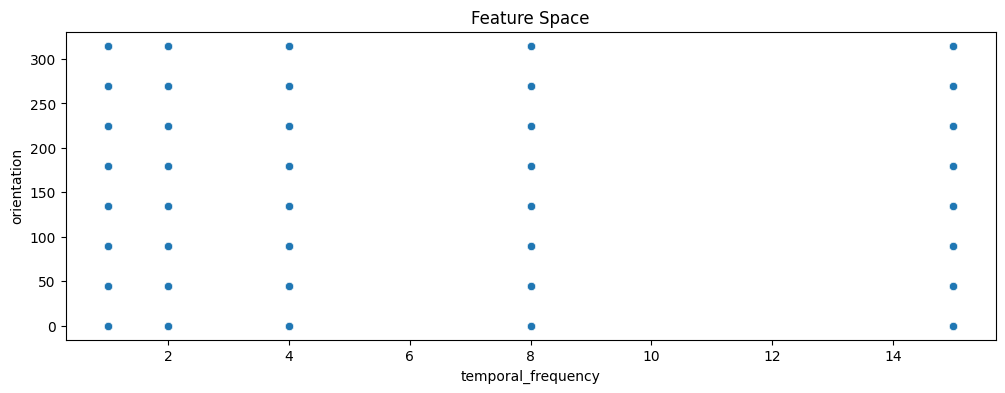

In [14]:
plot_feature_space(dataset_drifting, x_col=features_drifting[0], y_col=features_drifting[1], title='Feature Space')

We  try to use two unsupervised algorithms to cluster the data (KMeans and and Hierarchical Clustering).
In this algorithm we can fix apriori the number of clusters, so we fix it equal to the number of areas of the brain, since we would like to see if the algorithm is able to cluster the features in the same way as the areas of the brain.
As the feature space has few elements and is rather regular, we do not expect unsupervised algorithms to work effectively.


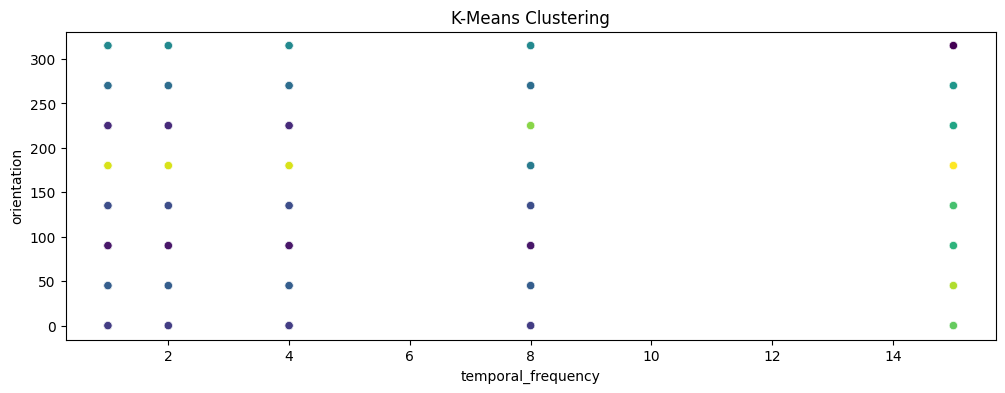

,stimulus_presentation_id,area,temporal_frequency,orientation,active,KMeans_Cluster
0,3798,APN,15.0,0.0,1,13
1,3798,CA1,15.0,0.0,1,13
2,3798,CA2,15.0,0.0,1,13
3,3798,CA3,15.0,0.0,0,13
4,3798,DG,15.0,0.0,1,13
...,...,...,...,...,...,...
10795,49432,VISal,1.0,180.0,1,16
10796,49432,VISam,1.0,180.0,1,16
10797,49432,VISl,1.0,180.0,0,16
10798,49432,VISp,1.0,180.0,1,16


In [15]:
apply_kmeans_clustering(dataset_drifting, n_clusters=n_classes, x_col=features_drifting[0], y_col=features_drifting[1])

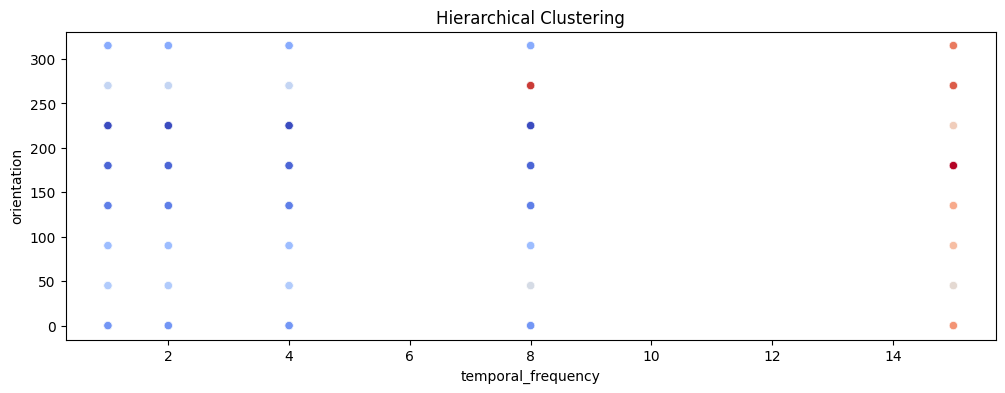

,stimulus_presentation_id,area,temporal_frequency,orientation,active,KMeans_Cluster,Hierarchical_Cluster
0,3798,APN,15.0,0.0,1,13,13
1,3798,CA1,15.0,0.0,1,13,13
2,3798,CA2,15.0,0.0,1,13,13
3,3798,CA3,15.0,0.0,0,13,13
4,3798,DG,15.0,0.0,1,13,13
...,...,...,...,...,...,...,...
10795,49432,VISal,1.0,180.0,1,16,1
10796,49432,VISam,1.0,180.0,1,16,1
10797,49432,VISl,1.0,180.0,0,16,1
10798,49432,VISp,1.0,180.0,1,16,1


In [16]:
apply_hierarchical_clustering(dataset_drifting, n_clusters=n_classes, x_col=features_drifting[0], y_col=features_drifting[1])

It's interesting to note that the KMeans algorith and the Hierarchical Clustering algorithm give different results, but we don't know which one is the best in clustering different areas of the brain. So we check it

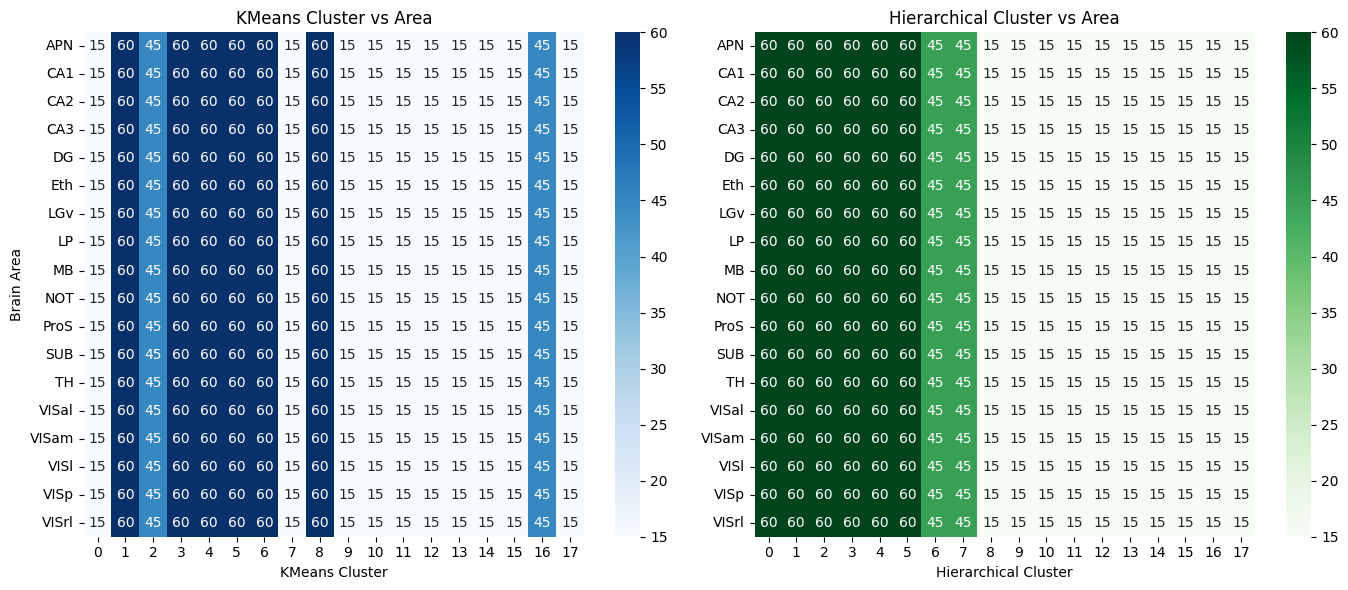

In [27]:
plot_area_cluster_heatmaps(dataset_drifting)

As expected, clustering algorithms do not work well in this case, as the feature space is too regular, so each cluster will contain exactly the same number of elements for each area of the brain.
We need to try a supervised algorithm to see if it can find if some combinations of features are predictive of the activation of a specific area of the brain.

## Supervised classification: XGBoost

We will train a XGBoost classifier for each area of the brain. The classifier will be trained on the features 'temporal_frequency' and 'orientation' and will predict the activation of the area of the brain.

We choose to train different models for each area of the brain, because we think that the features that are predictive of the activation of an area of the brain may be different for each area.

Moreover we will train a model only if the area of the brain is not always activated (or disactivated), otherwise the model would be useless.

In [18]:
models_drifting, results_drifting, label_encoder = train_area_models(dataset_drifting, features=features_drifting, label_col='active', area_col='area')

Training model for area: APN
Training model for area: CA1
Training model for area: CA2
Training model for area: CA3
Training model for area: DG
Training model for area: Eth
Skipping area Eth — only one class present: [1]
Training model for area: LGv
Skipping area LGv — only one class present: [1]
Training model for area: LP
Training model for area: MB
Training model for area: NOT
Training model for area: ProS
Training model for area: SUB
Training model for area: TH
Skipping area TH — only one class present: [1]
Training model for area: VISal
Training model for area: VISam
Training model for area: VISl
Training model for area: VISp
Training model for area: VISrl


Classification Report for Area: APN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      1.00       119

    accuracy                           0.99       120
   macro avg       0.50      0.50      0.50       120
weighted avg       0.98      0.99      0.99       120


Classification Report for Area: CA1
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        77
           1       0.20      0.05      0.08        43

    accuracy                           0.59       120
   macro avg       0.41      0.47      0.41       120
weighted avg       0.47      0.59      0.50       120


Classification Report for Area: CA2
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       105
           1       0.00      0.00      0.00        15

    accuracy                           0.88       120
   macro avg      

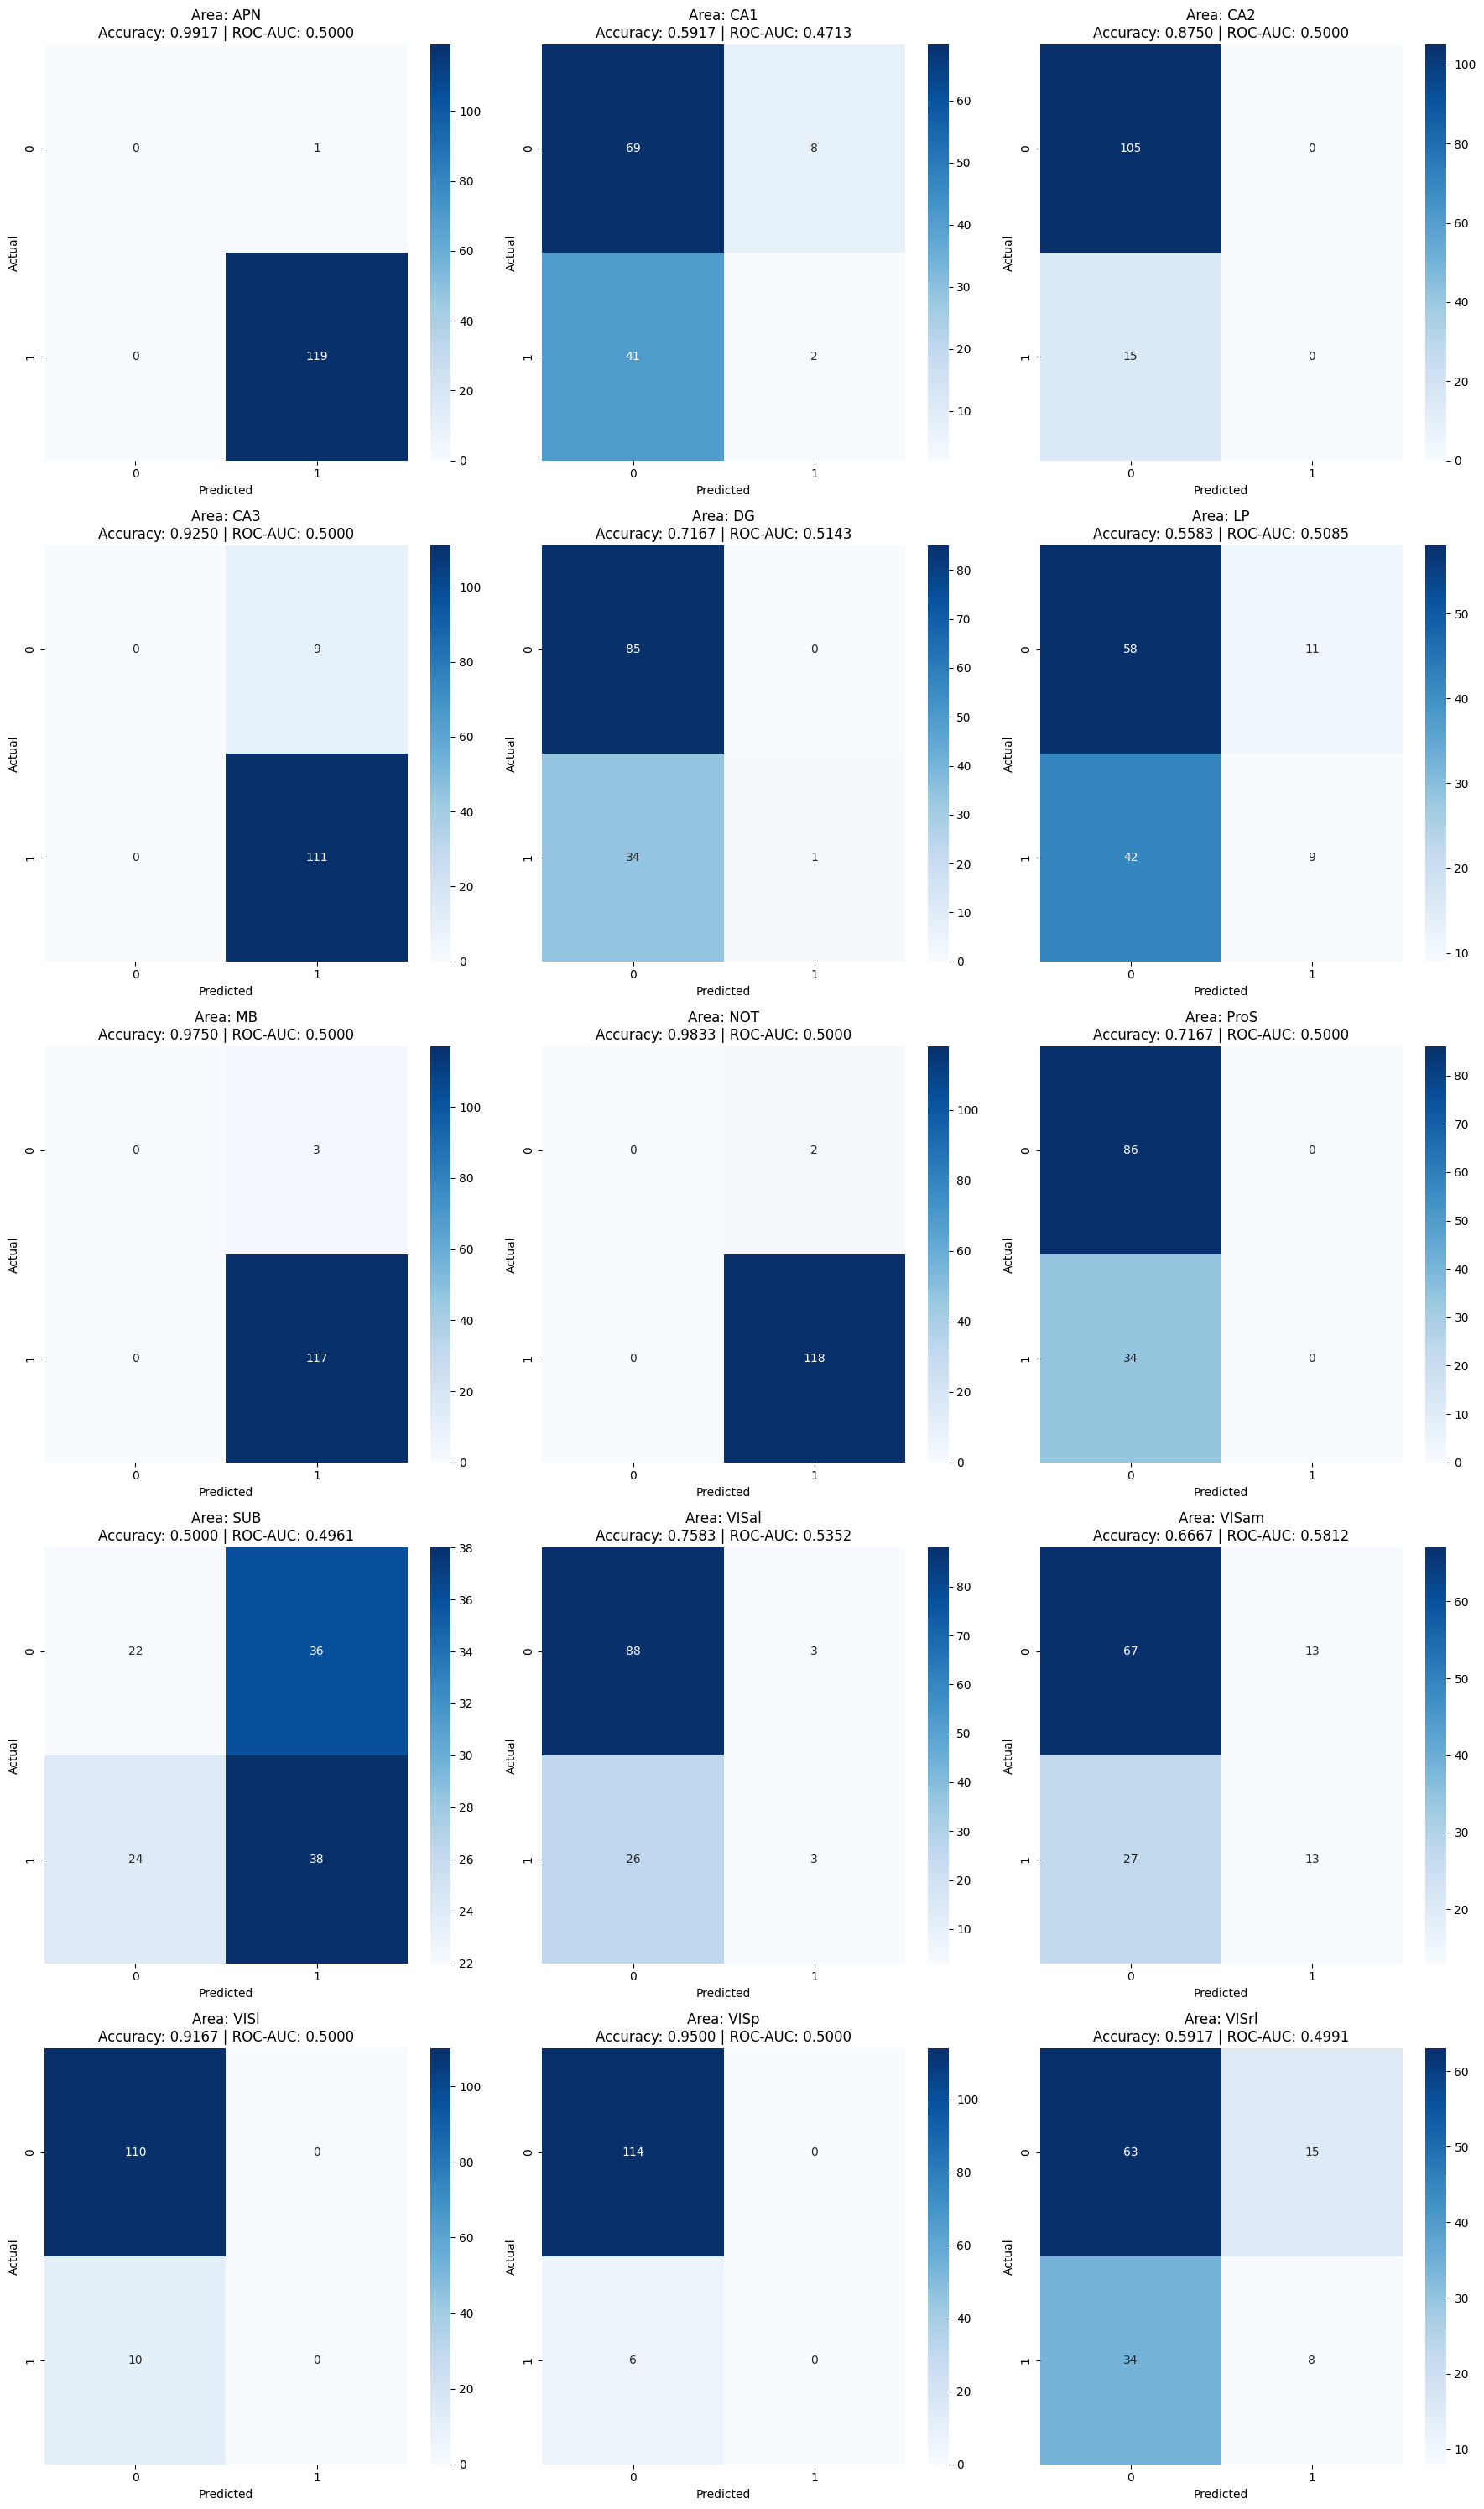

In [19]:
evaluate_and_plot_results(results_drifting, label_encoder=label_encoder)

In [20]:
compare_with_baseline(results_drifting)

Area: APN
Model Accuracy: 0.9917
Baseline (Most Frequent Class) Accuracy: 0.9917
⚠️ Warning: Model is not performing better than the baseline.

Area: CA1
Model Accuracy: 0.5917
Baseline (Most Frequent Class) Accuracy: 0.6417
⚠️ Warning: Model is not performing better than the baseline.

Area: CA2
Model Accuracy: 0.8750
Baseline (Most Frequent Class) Accuracy: 0.8750
⚠️ Warning: Model is not performing better than the baseline.

Area: CA3
Model Accuracy: 0.9250
Baseline (Most Frequent Class) Accuracy: 0.9250
⚠️ Warning: Model is not performing better than the baseline.

Area: DG
Model Accuracy: 0.7167
Baseline (Most Frequent Class) Accuracy: 0.7083
✅ Model is performing better than the baseline.

Area: LP
Model Accuracy: 0.5583
Baseline (Most Frequent Class) Accuracy: 0.5750
⚠️ Warning: Model is not performing better than the baseline.

Area: MB
Model Accuracy: 0.9750
Baseline (Most Frequent Class) Accuracy: 0.9750
⚠️ Warning: Model is not performing better than the baseline.

Area: NOT

{}

Now we do the same analysis for the Static Gratings

In [21]:
dataset_static

NameError: name 'dataset_static' is not defined

In [ ]:
features_static = ['spatial_frequency', 'orientation']

In [ ]:
dataset_static['area'].unique()

In [ ]:
n_classes = len(dataset_static['area'].unique())

In [ ]:
plot_feature_space(dataset_static, x_col=features_static[0], y_col=features_static[1], title='Feature Space')

In [ ]:
apply_kmeans_clustering(dataset_static, n_clusters=n_classes, x_col=features_static[0], y_col=features_static[1])

In [ ]:
apply_hierarchical_clustering(dataset_static, n_clusters=n_classes, x_col=features_static[0], y_col=features_static[1])

In [ ]:
plot_area_cluster_heatmaps(dataset_static)

In [ ]:
models_static, results_static, label_encoder = train_area_models(dataset_static, features=features_static, label_col='active', area_col='area')

In [ ]:
evaluate_and_plot_results(results_static, label_encoder=label_encoder)

In [ ]:
compare_with_baseline(results_static)